# Project 4 

## Problem Statement

## Executive Summary

### Import libraries

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN

import pyreadr
import myfunctions as f
import io

%matplotlib inline

### Data Import

In [2]:
df_train = pd.read_csv('../datasets/train.csv')
df_test = pd.read_csv('../datasets/test.csv')
df_spray = pd.read_csv('../datasets/spray.csv')
df_weather = pd.read_csv('../datasets/weather.csv')

## Data Cleaning

### General Cleaning for all dataframes

In [3]:
df_train.head()

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
2,2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,1,0
3,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX PIPIENS/RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,1,0
4,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,4,0


In [4]:
df_weather.head()

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,...,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
0,1,2007-05-01,83,50,67,14,51,56,0,2,...,,0,M,0.0,0.00,29.10,29.82,1.7,27,9.2
1,2,2007-05-01,84,52,68,M,51,57,0,3,...,,M,M,M,0.00,29.18,29.82,2.7,25,9.6
2,1,2007-05-02,59,42,51,-3,42,47,14,0,...,BR,0,M,0.0,0.00,29.38,30.09,13.0,4,13.4
3,2,2007-05-02,60,43,52,M,42,47,13,0,...,BR HZ,M,M,M,0.00,29.44,30.08,13.3,2,13.4
4,1,2007-05-03,66,46,56,2,40,48,9,0,...,,0,M,0.0,0.00,29.39,30.12,11.7,7,11.9


In [5]:
df_spray.head()

,Date,Time,Latitude,Longitude
0,2011-08-29,6:56:58 PM,42.391623,-88.089163
1,2011-08-29,6:57:08 PM,42.391348,-88.089163
2,2011-08-29,6:57:18 PM,42.391022,-88.089157
3,2011-08-29,6:57:28 PM,42.390637,-88.089158
4,2011-08-29,6:57:38 PM,42.390410,-88.088858


In [6]:
# Apply lower() to column names for all 3 dataframes
df_weather.columns = df_weather.columns.str.lower()
df_train.columns = df_train.columns.str.lower()
df_spray.columns = df_spray.columns.str.lower()

In [7]:
# Check datatypes
print('Train dataset')
print(df_train.dtypes)
print()
print('Weather dataset')
print(df_weather.dtypes)
print()
print('Spray dataset')
print(df_spray.dtypes)
print()

Train dataset
date                       object
address                    object
species                    object
block                       int64
street                     object
trap                       object
addressnumberandstreet     object
latitude                  float64
longitude                 float64
addressaccuracy             int64
nummosquitos                int64
wnvpresent                  int64
dtype: object

Weather dataset
station          int64
date            object
tmax             int64
tmin             int64
tavg            object
depart          object
dewpoint         int64
wetbulb         object
heat            object
cool            object
sunrise         object
sunset          object
codesum         object
depth           object
water1          object
snowfall        object
preciptotal     object
stnpressure     object
sealevel        object
resultspeed    float64
resultdir        int64
avgspeed        object
dtype: object

Spray dataset
date        

In [8]:
# Change Date datatype to datetime
df_train['date'] = pd.to_datetime(df_train['date'])
df_weather['date'] = pd.to_datetime(df_weather['date'])
df_spray['date'] = pd.to_datetime(df_spray['date'])

In [9]:
# Check datatypes
print('Train dataset')
print(df_train.dtypes)
print()
print('Weather dataset')
print(df_weather.dtypes)
print()
print('Spray dataset')
print(df_spray.dtypes)
print()

Train dataset
date                      datetime64[ns]
address                           object
species                           object
block                              int64
street                            object
trap                              object
addressnumberandstreet            object
latitude                         float64
longitude                        float64
addressaccuracy                    int64
nummosquitos                       int64
wnvpresent                         int64
dtype: object

Weather dataset
station                 int64
date           datetime64[ns]
tmax                    int64
tmin                    int64
tavg                   object
depart                 object
dewpoint                int64
wetbulb                object
heat                   object
cool                   object
sunrise                object
sunset                 object
codesum                object
depth                  object
water1                 object
snowfall     

In [10]:
# Create `day`, `month` and `year` columns for all 3 dataframes
df_spray['day'] = df_spray['date'].map(lambda x: x.day)
df_spray['month'] = df_spray['date'].map(lambda x: x.month)
df_spray['year'] = df_spray['date'].map(lambda x: x.year)

df_weather['day'] = df_weather['date'].map(lambda x: x.day)
df_weather['month'] = df_weather['date'].map(lambda x: x.month)
df_weather['year'] = df_weather['date'].map(lambda x: x.year)

df_train['day'] = df_train['date'].map(lambda x: x.day)
df_train['month'] = df_train['date'].map(lambda x: x.month)
df_train['year'] = df_train['date'].map(lambda x: x.year)

In [11]:
# View data shapes
print(f'Train dataset: {df_train.shape}')
print(f'Weather dataset: {df_weather.shape}')
print(f'Spray dataset: {df_spray.shape}')

Train dataset: (10506, 15)
Weather dataset: (2944, 25)
Spray dataset: (14835, 7)


In [12]:
# Check for NA values
print(f'Train dataset: {df_train.isnull().sum().sum()}')
print(f'Weather dataset: {df_weather.isnull().sum().sum()}')
print(f'Spray dataset: {df_spray.isnull().sum().sum()}')

Train dataset: 0
Weather dataset: 0
Spray dataset: 584


### Data cleaning for df_spray

In [13]:
# Closer look at Spray dataset
print(df_spray.isnull().sum())

date           0
time         584
latitude       0
longitude      0
day            0
month          0
year           0
dtype: int64


**Comment**

Column 'Time' has 584 empty cells but it is not important for our analysis.
The null values does not appear at random. Therefore, we will drop the column

In [14]:
df_spray.drop(columns='time',inplace=True)

In [15]:
df_spray.head()

,date,latitude,longitude,day,month,year
0,2011-08-29,42.391623,-88.089163,29,8,2011
1,2011-08-29,42.391348,-88.089163,29,8,2011
2,2011-08-29,42.391022,-88.089157,29,8,2011
3,2011-08-29,42.390637,-88.089158,29,8,2011
4,2011-08-29,42.390410,-88.088858,29,8,2011


### Data cleaning for df_weather

In [16]:
# Define function to replace entires with M, blank spaces and '-' with Nan values, while T was replace with 0.05
# https://wgntv.com/weather/what-are-traces-of-precipitation/
def update_cols(df):
    df.replace(['M','-',' ', '  T'],
               [np.nan, np.nan, np.nan, 0.05],
               inplace = True)
    
update_cols(df_weather)

In [17]:
df_weather.head()
# Depart
# Departure from normal. The difference between column 4 and the 30 year normal temperature 
# for this date. A minus (-) is number of degrees below normal.
# A zero (0) indicates that the average for that day was the Normal.

# DewPoint
# The dew point is the temperature the air needs to be cooled to (at constant pressure) 
# in order to achieve a relative humidity (RH) of 100%.

# WetBulb
# At 100% relative humidity, the wet-bulb temperature is equal to the air temperature 
# (dry-bulb temperature) and it is lower at lower humidity.

,station,date,tmax,tmin,tavg,depart,dewpoint,wetbulb,heat,cool,...,snowfall,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed,day,month,year
0,1,2007-05-01,83,50,67,14,51,56,0,2,...,0.0,0.00,29.10,29.82,1.7,27,9.2,1,5,2007
1,2,2007-05-01,84,52,68,NaN,51,57,0,3,...,NaN,0.00,29.18,29.82,2.7,25,9.6,1,5,2007
2,1,2007-05-02,59,42,51,-3,42,47,14,0,...,0.0,0.00,29.38,30.09,13.0,4,13.4,2,5,2007
3,2,2007-05-02,60,43,52,NaN,42,47,13,0,...,NaN,0.00,29.44,30.08,13.3,2,13.4,2,5,2007
4,1,2007-05-03,66,46,56,2,40,48,9,0,...,0.0,0.00,29.39,30.12,11.7,7,11.9,3,5,2007


In [18]:
# Check for null
df_weather.isnull().sum().sort_values(ascending=False)

water1         2944
codesum        1609
depart         1472
sunrise        1472
sunset         1472
depth          1472
snowfall       1472
tavg             11
cool             11
heat             11
sealevel          9
stnpressure       4
wetbulb           4
avgspeed          3
preciptotal       2
tmin              0
tmax              0
date              0
year              0
dewpoint          0
month             0
resultspeed       0
resultdir         0
day               0
station           0
dtype: int64

In [19]:
# Drop water1 column as it is missing all the data
df_weather.drop(['water1'], axis = 1, inplace= True)

# Replace Nan values in codesum column with 'MODERATE'
df_weather['codesum'] = df_weather['codesum'].replace(np.nan, 'MODERATE')

In [20]:
df_weather.dtypes

station                 int64
date           datetime64[ns]
tmax                    int64
tmin                    int64
tavg                   object
depart                 object
dewpoint                int64
wetbulb                object
heat                   object
cool                   object
sunrise                object
sunset                 object
codesum                object
depth                  object
snowfall               object
preciptotal            object
stnpressure            object
sealevel               object
resultspeed           float64
resultdir               int64
avgspeed               object
day                     int64
month                   int64
year                    int64
dtype: object

In [21]:
col_toflt = ['preciptotal', 'stnpressure', 'sealevel',
             'avgspeed', 'preciptotal', 'tavg',
             'depart', 'wetbulb', 'heat', 'cool',
             'sunrise', 'sunset']

for col in col_toflt:
    df_weather[col] = df_weather[col].astype(float)

In [22]:
df_weather.dtypes

station                 int64
date           datetime64[ns]
tmax                    int64
tmin                    int64
tavg                  float64
depart                float64
dewpoint                int64
wetbulb               float64
heat                  float64
cool                  float64
sunrise               float64
sunset                float64
codesum                object
depth                  object
snowfall               object
preciptotal           float64
stnpressure           float64
sealevel              float64
resultspeed           float64
resultdir               int64
avgspeed              float64
day                     int64
month                   int64
year                    int64
dtype: object

In [23]:
# Define function to convert temperature to Celsius
def fahrenheit_to_celsius(df,column_names):
    '''
    Convert temperature from Fahrenheit to Celsius
    
    Takes:
    df - DataFrame
    column_names - (list of str) - names of columns for conversion
    
    Returns:
    df
    '''
    for name in column_names:
        try:
            df[name] = round((df[name]-32)*5/9,2)
        except TypeError:
            continue
    return df

fahrenheit_to_celsius(df_weather,
                      ['tmax','tmin','tavg','depart','dewpoint','wetbulb'])

,station,date,tmax,tmin,tavg,depart,dewpoint,wetbulb,heat,cool,...,snowfall,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed,day,month,year
0,1,2007-05-01,28.33,10.00,19.44,-10.00,10.56,13.33,0.0,2.0,...,0.0,0.00,29.10,29.82,1.7,27,9.2,1,5,2007
1,2,2007-05-01,28.89,11.11,20.00,NaN,10.56,13.89,0.0,3.0,...,NaN,0.00,29.18,29.82,2.7,25,9.6,1,5,2007
2,1,2007-05-02,15.00,5.56,10.56,-19.44,5.56,8.33,14.0,0.0,...,0.0,0.00,29.38,30.09,13.0,4,13.4,2,5,2007
3,2,2007-05-02,15.56,6.11,11.11,NaN,5.56,8.33,13.0,0.0,...,NaN,0.00,29.44,30.08,13.3,2,13.4,2,5,2007
4,1,2007-05-03,18.89,7.78,13.33,-16.67,4.44,8.89,9.0,0.0,...,0.0,0.00,29.39,30.12,11.7,7,11.9,3,5,2007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2939,2,2014-10-29,9.44,4.44,7.22,NaN,1.11,5.56,20.0,0.0,...,NaN,0.00,29.42,30.07,8.5,29,9.0,29,10,2014
2940,1,2014-10-30,10.56,0.00,5.56,-20.00,1.11,4.44,23.0,0.0,...,0.0,0.00,29.34,30.09,5.1,24,5.5,30,10,2014
2941,2,2014-10-30,11.67,2.78,7.22,NaN,1.67,5.56,20.0,0.0,...,NaN,0.05,29.41,30.10,5.9,23,6.5,30,10,2014
2942,1,2014-10-31,8.33,0.56,4.44,-21.11,-3.89,0.56,25.0,0.0,...,0.1,0.03,29.49,30.20,22.6,34,22.9,31,10,2014


## Exploratory Data Analysis and Feature Engineering

### EDA - Weather dataset

In [24]:
# Masking weather data by station
df_weather_st1 = df_weather[df_weather['station']==1]
df_weather_st2 = df_weather[df_weather['station']==2]
# Resetting indices
df_weather_st1.reset_index(inplace=True,drop=True)
df_weather_st2.reset_index(inplace=True,drop=True)

In [25]:
# Checking for missing values from station 1
df_weather_st1.isnull().sum()

station        0
date           0
tmax           0
tmin           0
tavg           0
depart         0
dewpoint       0
wetbulb        3
heat           0
cool           0
sunrise        0
sunset         0
codesum        0
depth          0
snowfall       0
preciptotal    0
stnpressure    2
sealevel       5
resultspeed    0
resultdir      0
avgspeed       0
day            0
month          0
year           0
dtype: int64

In [26]:
# Checking for missing values from station 2
df_weather_st2.isnull().sum()
# There are much more missing values in station 2

station           0
date              0
tmax              0
tmin              0
tavg             11
depart         1472
dewpoint          0
wetbulb           1
heat             11
cool             11
sunrise        1472
sunset         1472
codesum           0
depth          1472
snowfall       1472
preciptotal       2
stnpressure       2
sealevel          4
resultspeed       0
resultdir         0
avgspeed          3
day               0
month             0
year              0
dtype: int64

In [27]:
# Merging two station in one df
weather_two_stations = pd.merge(df_weather_st1,df_weather_st2,on='date')

In [28]:
# Creation a function for scatter- and box-plots
def scatter(column_list,df=weather_two_stations):
    '''
    Plot station 1 against station 2
    '''
    nrows = int(np.ceil(len(column_list)/2))
    fig,ax=plt.subplots(nrows=nrows,ncols=2,figsize=(20,50))
    for i,name in enumerate(column_list):
        x = df[name + '_x']
        y = df[name +'_y']
        if i <=nrows-1:
            c=0
            a = i
        else:
            c=1
            a = i - nrows

        try:
            ax[a,c].scatter(x,y)
            ax[a,c].set_title(name,fontsize=15)
            ax[a,c].set_xlabel('Station 1')
            ax[a,c].set_xlabel('Station 2')
            plt.tight_layout(pad=0.4, w_pad=2, h_pad=2)
        except:
            pass

In [29]:
# Choosing columns for scatterplots
column_names = [name.split('_')[0] for name in ['station_x', 'tmax_x', 'tmin_x', 
                                                'tavg_x', 'depart_x',
       'dewpoint_x', 'wetbulb_x', 'heat_x', 'cool_x', 'sunrise_x', 'sunset_x',
       'codesum_x', 'depth_x', 'snowfall_x', 'preciptotal_x', 'stnpressure_x',
       'sealevel_x', 'resultspeed_x', 'resultdir_x', 'avgspeed_x', 'day_x',
       'month_x', 'year_x', 'station_y', 'tmax_y', 'tmin_y', 'tavg_y',
       'depart_y', 'dewpoint_y', 'wetbulb_y', 'heat_y', 'cool_y', 'sunrise_y',
       'sunset_y', 'codesum_y', 'depth_y', 'snowfall_y', 'preciptotal_y',
       'stnpressure_y', 'sealevel_y', 'resultspeed_y', 'resultdir_y',
       'avgspeed_y', 'day_y', 'month_y', 'year_y']]
# Leave only unique names of columns
column_names = list(set(column_names))

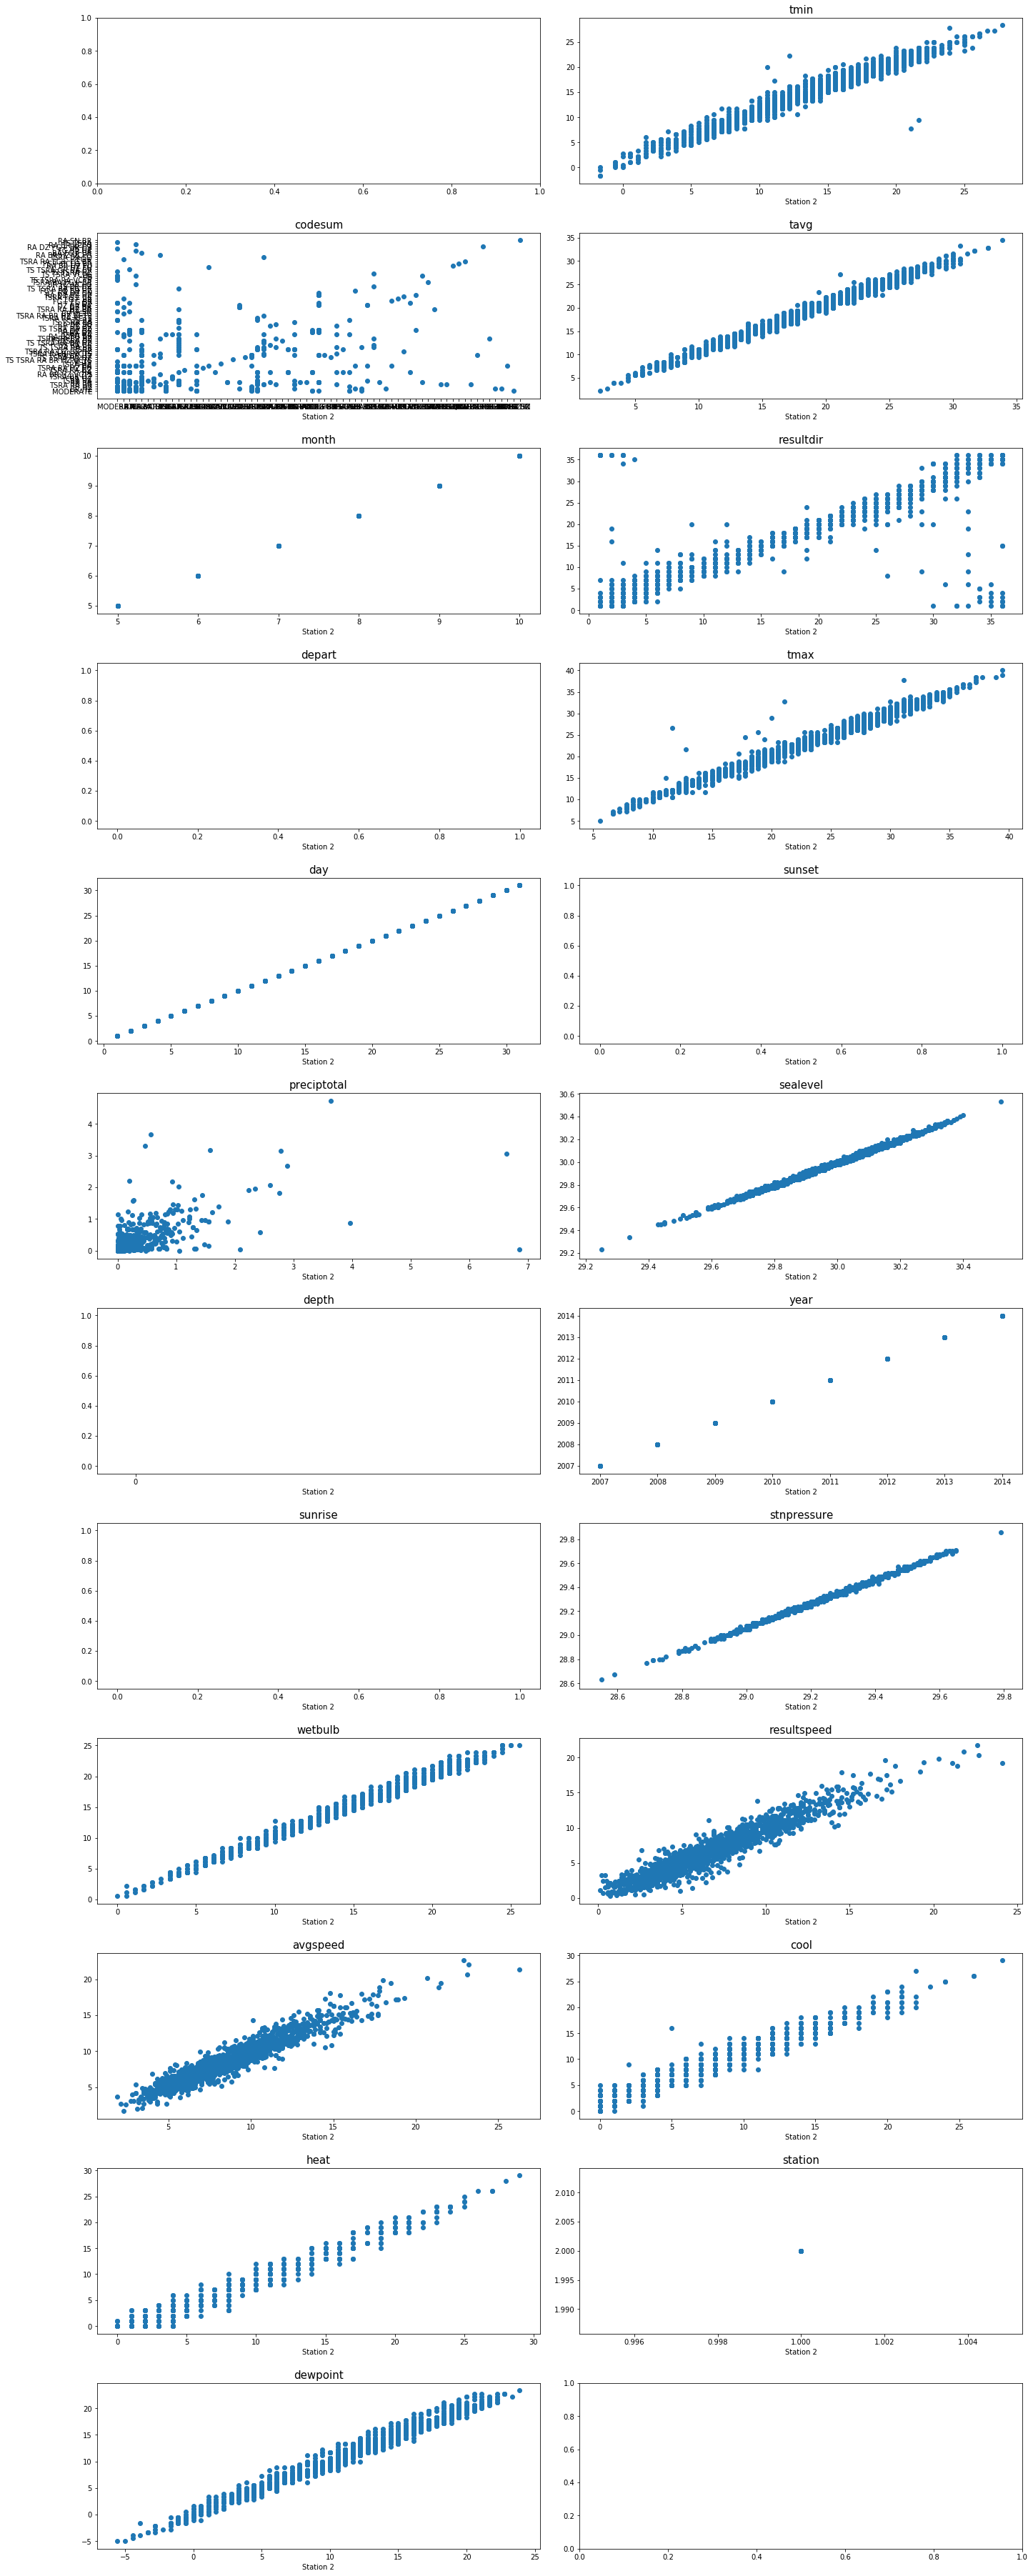

In [30]:
scatter(column_names)

As graphs above have shown, weather data from station 1 and station 2 is very similar.
But station 1 has much less missing values. The decision is to fill NA in station 1 with info from station 2 and drop station 2 columns.

In [31]:
index_st1=df_weather_st1[df_weather_st1.isnull().any(axis=1)].index
df_weather_st1[df_weather_st1.isnull().any(axis=1)]

,station,date,tmax,tmin,tavg,depart,dewpoint,wetbulb,heat,cool,...,snowfall,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed,day,month,year
416,1,2009-06-18,26.67,16.11,21.67,-17.22,17.22,19.44,0.0,6.0,...,0.0,0.12,29.08,NaN,6.7,16,7.9,18,6,2009
424,1,2009-06-26,30.00,20.56,25.56,-13.89,15.56,NaN,0.0,13.0,...,0.0,0.00,NaN,29.85,6.4,4,8.2,26,6,2009
497,1,2009-09-07,25.00,15.00,20.00,-17.22,15.00,16.67,0.0,3.0,...,0.0,0.00,29.39,NaN,5.8,3,4.0,7,9,2009
866,1,2011-09-08,23.89,13.89,18.89,-17.78,11.67,15.00,0.0,1.0,...,0.0,0.05,29.34,NaN,13.0,2,13.4,8,9,2011
878,1,2011-09-20,23.33,9.44,16.67,-17.78,12.22,14.44,3.0,0.0,...,0.0,0.00,29.26,NaN,7.3,18,7.3,20,9,2011
1045,1,2012-09-03,31.11,21.67,26.67,-11.11,21.11,22.78,0.0,15.0,...,0.0,0.00,29.17,NaN,4.6,6,4.4,3,9,2012
1205,1,2013-08-10,27.22,17.78,22.78,-17.78,13.89,NaN,0.0,8.0,...,0.0,0.00,NaN,30.08,5.3,5,6.5,10,8,2013
1206,1,2013-08-11,27.22,15.56,21.67,-18.89,16.11,NaN,0.0,6.0,...,0.0,0.01,29.35,30.07,2.0,27,3.0,11,8,2013


In [32]:
df_weather_st2.loc[index_st1,:]

,station,date,tmax,tmin,tavg,depart,dewpoint,wetbulb,heat,cool,...,snowfall,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed,day,month,year
416,2,2009-06-18,27.22,17.22,22.22,NaN,17.78,19.44,0.0,7.0,...,NaN,0.11,29.15,29.79,3.7,17,5.8,18,6,2009
424,2,2009-06-26,30.00,22.22,26.11,NaN,16.11,19.44,0.0,14.0,...,NaN,0.00,29.20,29.83,6.4,4,8.0,26,6,2009
497,2,2009-09-07,25.00,17.22,21.11,NaN,15.00,17.22,0.0,5.0,...,NaN,0.00,29.44,30.09,6.3,4,6.9,7,9,2009
866,2,2011-09-08,23.33,16.67,20.00,NaN,12.22,15.00,0.0,3.0,...,NaN,0.06,29.36,30.03,14.9,2,15.2,8,9,2011
878,2,2011-09-20,23.89,11.67,17.78,NaN,12.22,14.44,1.0,0.0,...,NaN,0.01,29.33,29.99,5.8,17,6.1,20,9,2011
1045,2,2012-09-03,30.56,22.78,26.67,NaN,20.56,22.78,0.0,15.0,...,NaN,0.00,29.23,29.87,5.0,7,5.9,3,9,2012
1205,2,2013-08-10,27.22,20.00,23.89,NaN,12.78,17.22,0.0,10.0,...,NaN,0.00,NaN,30.07,6.0,6,7.4,10,8,2013
1206,2,2013-08-11,28.89,17.22,23.33,NaN,13.89,17.78,0.0,9.0,...,NaN,0.05,29.42,30.06,4.0,24,5.4,11,8,2013


In [33]:
# Filling NA in station 1 with info from station 2
df_weather_st1.loc[:,'wetbulb'].fillna(df_weather_st2['wetbulb'],inplace=True)
df_weather_st1.loc[:,'stnpressure'].fillna(df_weather_st2['stnpressure'],inplace=True)
df_weather_st1.loc[:,'sealevel'].fillna(df_weather_st2['sealevel'],inplace=True)
# row with index 1205 don't have value in both stations. 
# It will be filled with info from the next day
df_weather_st1.loc[:,'stnpressure'].fillna(29.42,inplace=True);

C:\Users\admin\Anaconda3\lib\site-packages\pandas\core\generic.py:6287: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [34]:
df_weather_st1.isnull().sum()
# now we don't have missing values in weather df

station        0
date           0
tmax           0
tmin           0
tavg           0
depart         0
dewpoint       0
wetbulb        0
heat           0
cool           0
sunrise        0
sunset         0
codesum        0
depth          0
snowfall       0
preciptotal    0
stnpressure    0
sealevel       0
resultspeed    0
resultdir      0
avgspeed       0
day            0
month          0
year           0
dtype: int64

In [35]:
numeric_df = df_weather_st1._get_numeric_data()

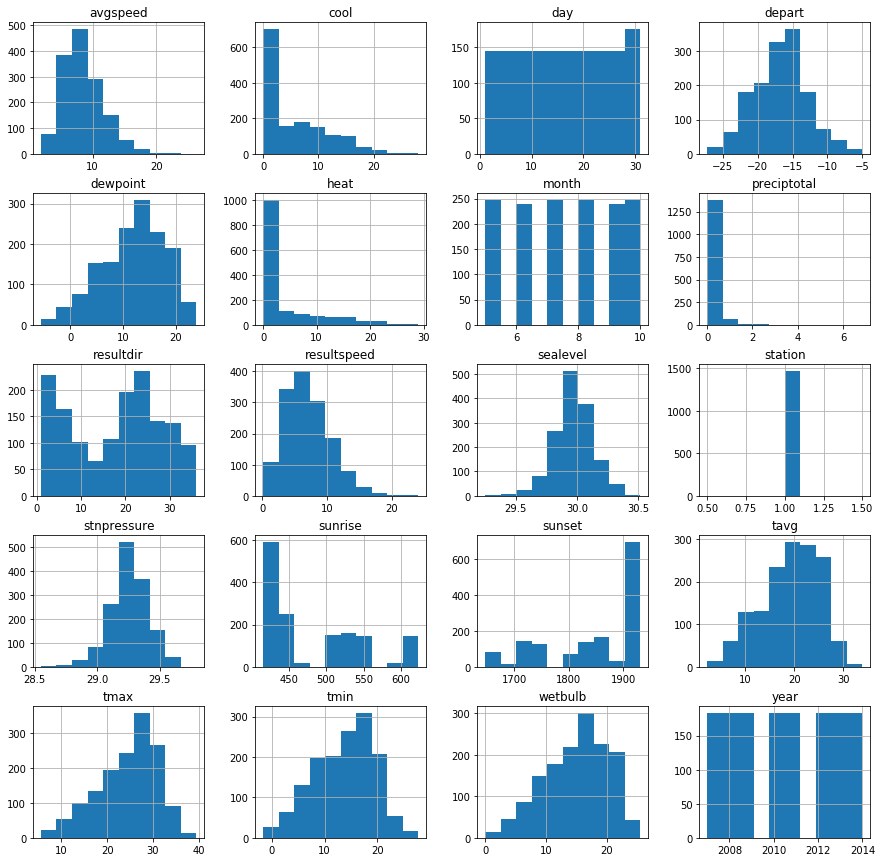

In [36]:
numeric_df.hist(figsize=(15,15));

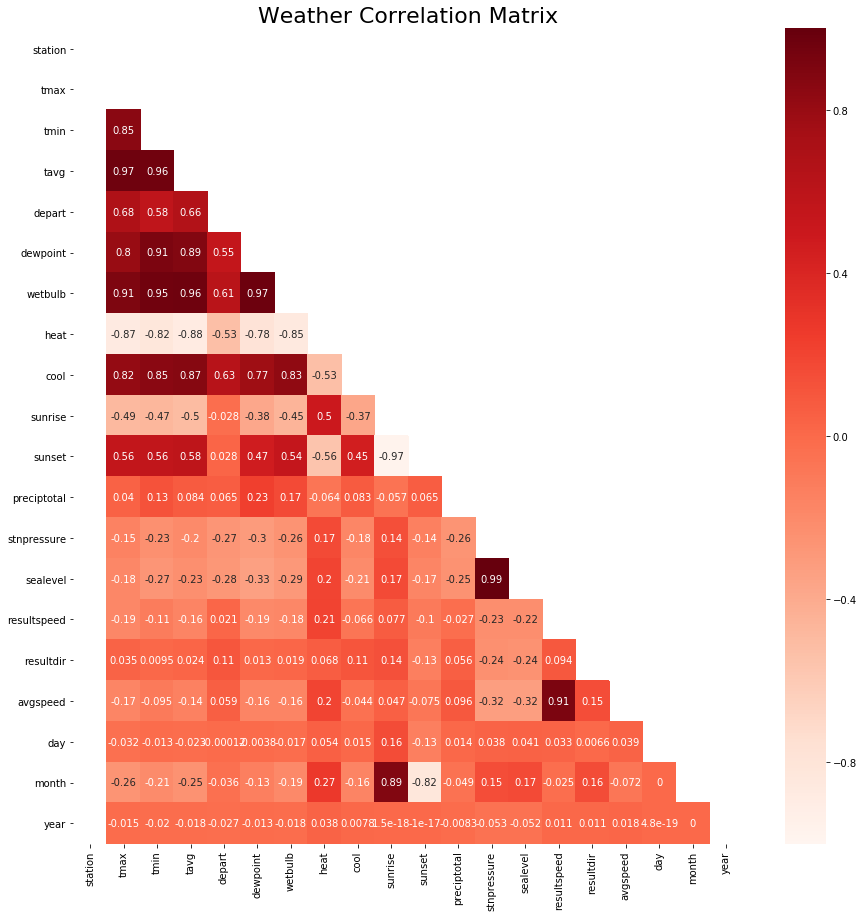

In [37]:
# Setting up the size of the figure
plt.figure(figsize=(15,15))
# Insert the title 
plt.title("Weather Correlation Matrix", fontsize=22) 
corr = numeric_df.corr()
# Set up mask to be True to hide upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
heat_map = sns.heatmap(corr,mask=mask,annot=True,vmin=-1,vmax=1,cmap="Reds")

### EDA - Spray dataset

In [38]:
# Choosing columns for clustering
X = df_spray[['day', 'month','year','latitude', 'longitude']]

In [39]:
# Standartizing data
ss = StandardScaler()
X_scaled = ss.fit_transform(X)
# Training DBSCAN for predicting 
dbs = DBSCAN(eps=0.1)
dbs.fit(X)

DBSCAN(eps=0.1)

In [40]:
# Verifying labels (there should be 13)
np.unique(dbs.labels_)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12], dtype=int64)

In [41]:
# Adding labels to spray df
df_spray['labels'] = dbs.labels_

In [42]:
df_spray.head()

,date,latitude,longitude,day,month,year,labels
0,2011-08-29,42.391623,-88.089163,29,8,2011,0
1,2011-08-29,42.391348,-88.089163,29,8,2011,0
2,2011-08-29,42.391022,-88.089157,29,8,2011,0
3,2011-08-29,42.390637,-88.089158,29,8,2011,0
4,2011-08-29,42.390410,-88.088858,29,8,2011,0


In [43]:
df_spray = df_spray.loc[df_spray['longitude'] > -88]

In [44]:
# Looking at result
clusteres_df = df_spray.groupby(['labels','date']).count()
clusteres_df.sort_values('date')

,,latitude,longitude,day,month,year
labels,date,,,,,
1,2011-09-07,2114,2114,2114,2114,2114
2,2013-07-17,556,556,556,556,556
3,2013-07-17,1646,1646,1646,1646,1646
4,2013-07-25,1607,1607,1607,1607,1607
5,2013-08-08,1195,1195,1195,1195,1195
6,2013-08-15,2668,2668,2668,2668,2668
7,2013-08-16,141,141,141,141,141
8,2013-08-22,845,845,845,845,845
9,2013-08-22,742,742,742,742,742


In [45]:
# Defining min and max latitudes and longitudes for each cluster
min_spray = max_spray = df_spray.groupby('labels')[['date','latitude','longitude']].min()
max_spray = max_spray = df_spray.groupby('labels')[['latitude','longitude']].max()

In [46]:
# Merging min and max df in one
min_max_spray = pd.merge(min_spray,max_spray,on='labels')
# Renaming columns to make them more understandable
min_max_spray.columns = ['date', 'latitude_min', 'longitude_min', 'latitude_max', 'longitude_max'] 

In [47]:
min_max_spray

,date,latitude_min,longitude_min,latitude_max,longitude_max
labels,,,,,
1,2011-09-07,41.968435,-87.836560,41.997028,-87.787710
2,2013-07-17,41.972617,-87.871023,42.015098,-87.762165
3,2013-07-17,41.714098,-87.672362,41.743287,-87.629355
4,2013-07-25,41.939308,-87.739840,41.968097,-87.707987
5,2013-08-08,41.917227,-87.716847,41.946703,-87.678060
6,2013-08-15,41.887825,-87.818408,41.966532,-87.745625
7,2013-08-16,41.911375,-87.785792,41.964712,-87.746675
8,2013-08-22,41.873487,-87.730655,41.895475,-87.701623
9,2013-08-22,41.713925,-87.623142,41.765277,-87.586727


### EDA - Train dataset

In [48]:
df_train.head()

,date,address,species,block,street,trap,addressnumberandstreet,latitude,longitude,addressaccuracy,nummosquitos,wnvpresent,day,month,year
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0,29,5,2007
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0,29,5,2007
2,2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,1,0,29,5,2007
3,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX PIPIENS/RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,1,0,29,5,2007
4,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,4,0,29,5,2007


### Merge df_train and df_weather for EDA

In [49]:
# Codes
# Create temproray dataframe by merging cleaned df_train and df_weather dataframes
df = pd.merge(df_train, df_weather_st1, on="date")

# Select a few columns for analysis
df = df[['date', 'nummosquitos', 'species', 'tavg', 'wnvpresent', 'sealevel', 'dewpoint', 'wetbulb', 'preciptotal', 'stnpressure']]

# Create another temporary variable, this is the mean temperature, mosquitos and wnv present
df_mean = df.groupby(['date']).mean()

# Segregate species that carry WNV or not
df['wnvspecies'] = [1 if ('PIPIENS' or 'RESTUANS') in row else 0 for row in df['species']]

# Segregate Non-Pipiens / Restuans (0), Pip&Rest w/o WNV (1), Pip&Rest with WNV (0)
df['3cat'] = df['wnvspecies'] + df['wnvpresent']

# Create 2 temporary dataframes to categorise data by month (average for weather, total for mosquito and virus data)
df_date = df.groupby('date')['nummosquitos','wnvpresent'].sum()
df_temp = df.groupby('date')['tavg','wetbulb'].mean()
df_date['tavg'] = df_temp['tavg']
df_date['wetbulb'] = df_temp['wetbulb']

df_date_month = df_date.groupby(by=[df_date.index.month])['nummosquitos','wnvpresent'].sum()
df_temp_month = df_date.groupby(by=[df_date.index.month])['tavg','wetbulb'].mean()
df_date_month['tavg'] = df_temp_month['tavg']
df_date_month['wetbulb'] = df_temp_month['wetbulb']

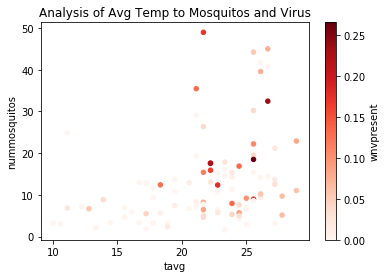

In [50]:
# Higher Temperature = More Mosquitos = Higher weightage of WNV Present

fig, ax = plt.subplots()
df_mean.plot.scatter(x='tavg', y='nummosquitos', c='wnvpresent', colormap='Reds', ax=ax)
ax.set_title('Analysis of Avg Temp to Mosquitos and Virus');

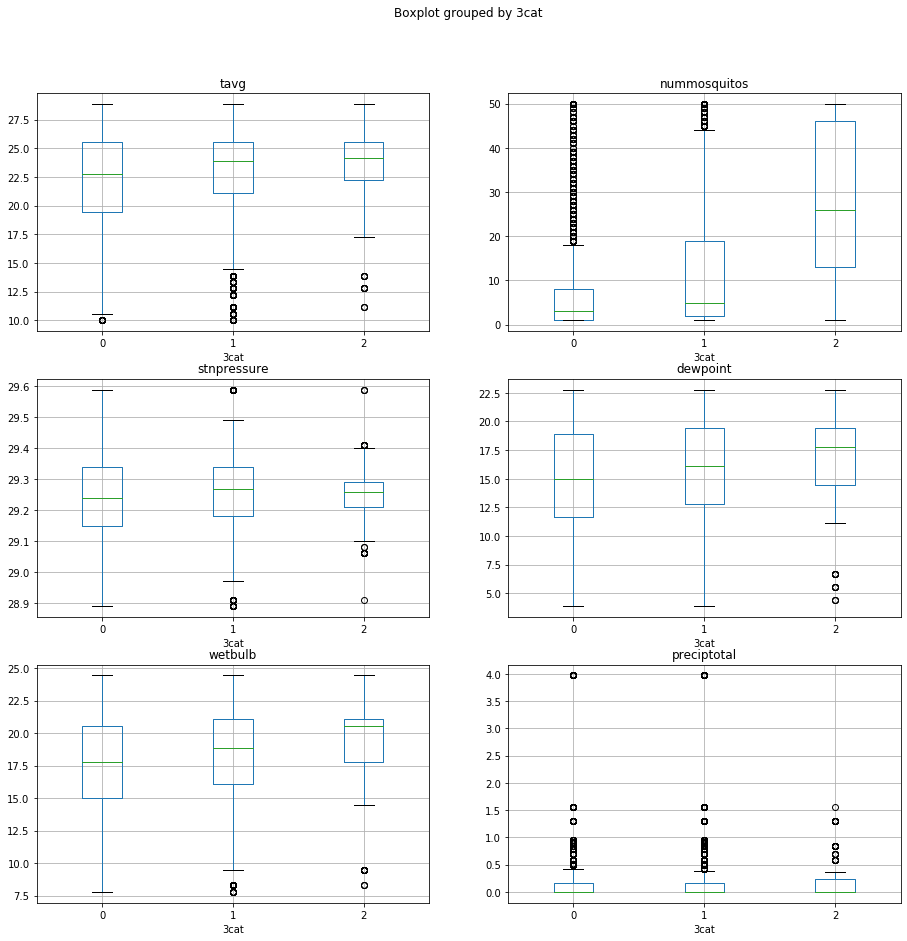

In [51]:
# Category labels:
# 0 [Non-Pipiens & Restuans (Statistically 0 WNV Present)]
# 1 [Pipiens & Restuans with NO WNV]
# 2 [Pipiens & Restuans WITH WNV]

fig, axes = plt.subplots(nrows=3, ncols=2,figsize=(15,15)) 

df.boxplot(column='tavg', by='3cat', ax=axes[0,0]) 
df.boxplot(column='nummosquitos', by='3cat', ax=axes[0,1]) 
df.boxplot(column='stnpressure', by='3cat', ax=axes[1,0]) 
df.boxplot(column='dewpoint', by='3cat', ax=axes[1,1]) 
df.boxplot(column='wetbulb', by='3cat', ax=axes[2,0]) 
df.boxplot(column='preciptotal', by='3cat', ax=axes[2,1]) 

plt.show()

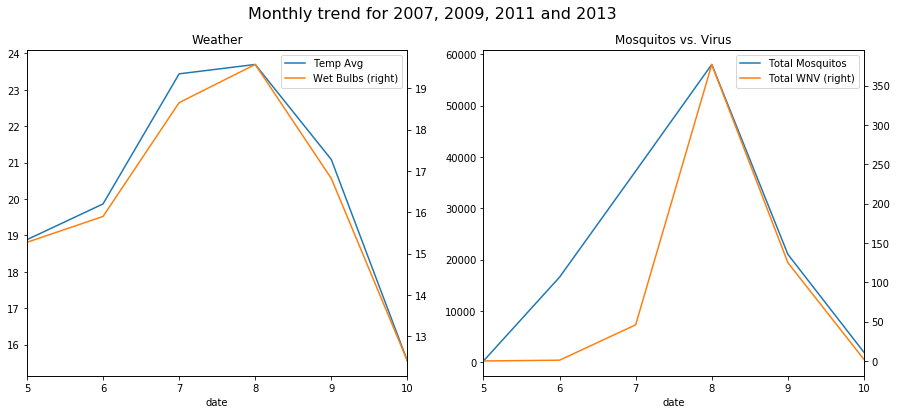

In [52]:
# Month by month analysis for training dataset

fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(15,6))

fig.suptitle("Monthly trend for 2007, 2009, 2011 and 2013", fontsize=16)
df_date_month.tavg.plot(label="Temp Avg", legend=True, ax=axes[0])
df_date_month.wetbulb.plot(secondary_y=True, label="Wet Bulbs", legend=True, ax=axes[0])
axes[0].set_title('Weather')

df_date_month.nummosquitos.plot(label='Total Mosquitos', legend=True,  ax=axes[1]) 
df_date_month.wnvpresent.plot(label='Total WNV', legend=True, ax=axes[1], secondary_y=True)
axes[1].set_title('Mosquitos vs. Virus')

plt.show()

### Bryan Pushing his EDA Here /End

#### Merge df_train by date, followed by by trap

In [53]:
df_train_groupbydate_trap = df_train.groupby(['date','trap'])

In [54]:
def chkWNV(series):
    return 1 if series.sum() > 0 else 0

In [55]:
# Merge by Date, followed by Trap
df_train_bydate_trap = pd.DataFrame(columns=['date', 'address', 'species',
                                             'block', 'street', 'trap',
                                             'addressnumberandstreet',
                                             'latitude', 'longitude',
                                             'addressaccuracy',
                                             'nummosquitos', 'wnvpresent'])

for date_trap, df in df_train_groupbydate_trap:
    df_train_bydate_trap.loc[len(df_train_bydate_trap)] = [date_trap[0],
                                                           np.unique(df['address'])[0],
                                                           np.unique(df['species']),
                                                           np.unique(df['block'])[0],
                                                           np.unique(df['street'])[0],
                                                           date_trap[1], 
                                                           np.unique(df['addressnumberandstreet'])[0], 
                                                           np.unique(df['latitude'])[0],
                                                           np.unique(df['longitude'])[0],
                                                           np.unique(df['addressaccuracy'])[0],
                                                           sum(df['nummosquitos']),
                                                           chkWNV(df['wnvpresent'])]

In [56]:
df_train_bydate_trap.head()

,date,address,species,block,street,trap,addressnumberandstreet,latitude,longitude,addressaccuracy,nummosquitos,wnvpresent
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...","[CULEX PIPIENS/RESTUANS, CULEX RESTUANS]",41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,2,0
1,2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",[CULEX RESTUANS],62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,1,0
2,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA","[CULEX PIPIENS/RESTUANS, CULEX RESTUANS]",79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,5,0
3,2007-05-29,"1500 West Webster Avenue, Chicago, IL 60614, USA",[CULEX RESTUANS],15,W WEBSTER AVE,T045,"1500 W WEBSTER AVE, Chicago, IL",41.921600,-87.666455,8,2,0
4,2007-05-29,"2500 West Grand Avenue, Chicago, IL 60654, USA",[CULEX RESTUANS],25,W GRAND AVE,T046,"2500 W GRAND AVE, Chicago, IL",41.891118,-87.654491,8,1,0


In [57]:
df_train_bydate_trap['species'] = df_train_bydate_trap['species'].apply(','.join)

In [58]:
df_train_bydate_trap['iswnvspecies'] = df_train_bydate_trap['species'].str.contains('PIPIENS|RESTUANS').astype(int)

In [59]:
df_train_bydate_trap.head()

,date,address,species,block,street,trap,addressnumberandstreet,latitude,longitude,addressaccuracy,nummosquitos,wnvpresent,iswnvspecies
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...","CULEX PIPIENS/RESTUANS,CULEX RESTUANS",41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,2,0,1
1,2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,1,0,1
2,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA","CULEX PIPIENS/RESTUANS,CULEX RESTUANS",79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,5,0,1
3,2007-05-29,"1500 West Webster Avenue, Chicago, IL 60614, USA",CULEX RESTUANS,15,W WEBSTER AVE,T045,"1500 W WEBSTER AVE, Chicago, IL",41.921600,-87.666455,8,2,0,1
4,2007-05-29,"2500 West Grand Avenue, Chicago, IL 60654, USA",CULEX RESTUANS,25,W GRAND AVE,T046,"2500 W GRAND AVE, Chicago, IL",41.891118,-87.654491,8,1,0,1


In [60]:
len(df_train_bydate_trap['trap'].unique())

136

---

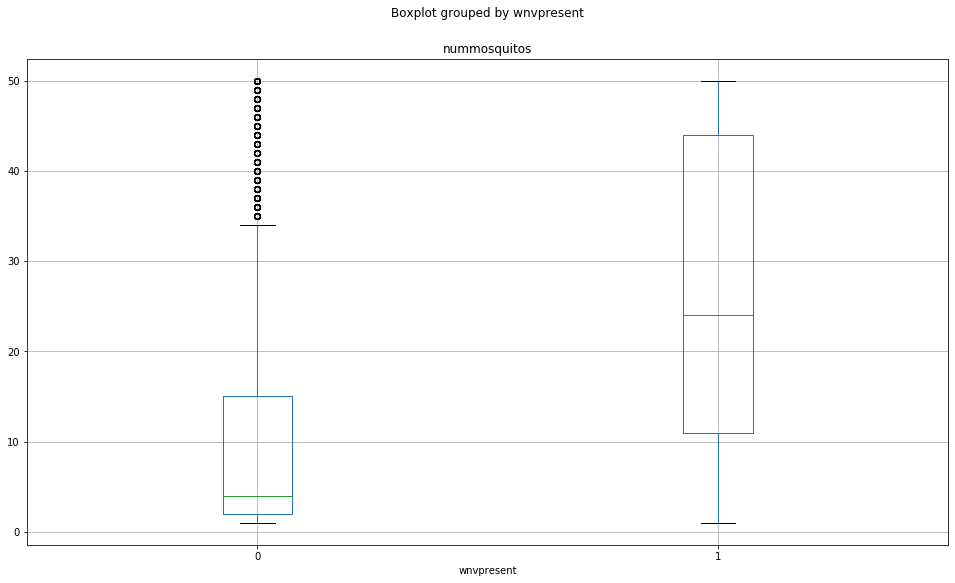

In [61]:
# Number of caught mosquitos by presence of virus
df_train.boxplot(by='wnvpresent',column='nummosquitos',figsize=(16,9));
# Virus is present if number of mosquitos is high

# These test results are organized in such a way that when the number of mosquitos exceed 50, 
# they are split into another record (another row in the dataset), 
# such that the number of mosquitos are capped at 50.

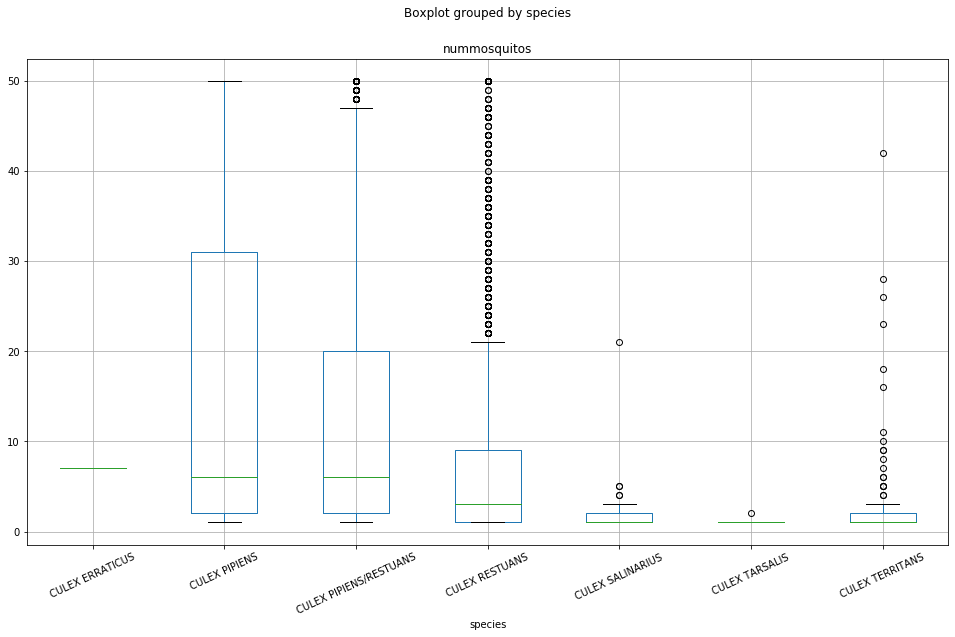

In [62]:
# Number of mosquitos by species of mosquitos
df_train.boxplot(by='species',column='nummosquitos',rot=25, figsize=(16,9));
# 2 species of mosquitos caught much frequently than others - Culex Pipiens and Culex Restuans

# Records exist only when a particular species of mosquitos is found at a certain trap 
# at a certain time. Date: date that the WNV test is performed

In [63]:
# NumMosquitos and WnvPresent by species
df_train.groupby('species')[['nummosquitos','wnvpresent']].sum()
# 2 species cought much frequantly and they contain virus - Also, Culex Pipiens and Culex Restuans
# ? does other species are rare in the area
# ? does it mean that other species can have the virus but due to their rareness we don't see it

,nummosquitos,wnvpresent
species,,
CULEX ERRATICUS,7,0
CULEX PIPIENS,44671,240
CULEX PIPIENS/RESTUANS,66268,262
CULEX RESTUANS,23431,49
CULEX SALINARIUS,145,0
CULEX TARSALIS,7,0
CULEX TERRITANS,510,0


In [64]:
df_train['trap'].value_counts()

T900     750
T115     542
T138     314
T002     185
T135     183
        ... 
T238       7
T076       5
T094B      5
T237       3
T040       2
Name: trap, Length: 136, dtype: int64

In [65]:
df_train['species'].value_counts()

CULEX PIPIENS/RESTUANS    4752
CULEX RESTUANS            2740
CULEX PIPIENS             2699
CULEX TERRITANS            222
CULEX SALINARIUS            86
CULEX TARSALIS               6
CULEX ERRATICUS              1
Name: species, dtype: int64

In [66]:
pd.pivot_table(df_train, index='species', values='wnvpresent')

,wnvpresent
species,
CULEX ERRATICUS,0.000000
CULEX PIPIENS,0.088922
CULEX PIPIENS/RESTUANS,0.055135
CULEX RESTUANS,0.017883
CULEX SALINARIUS,0.000000
CULEX TARSALIS,0.000000
CULEX TERRITANS,0.000000


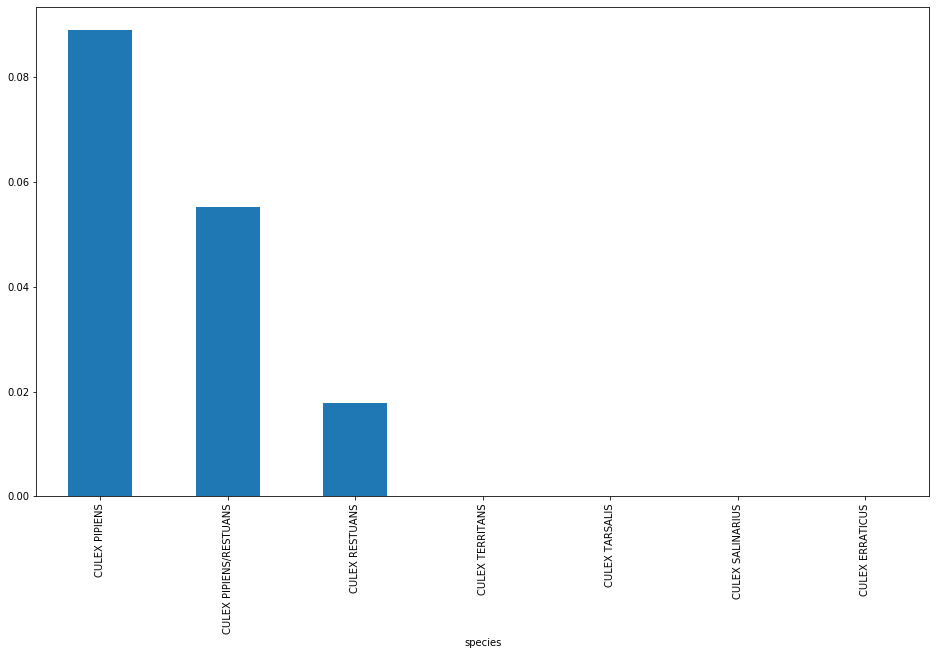

In [67]:
df_train.groupby('species')['wnvpresent'].mean().sort_values(ascending=False).plot.bar(figsize=(16,9));

**Comment**

Based on the above, only mosquitoes which are of the species Culex Pipiens, Culex Pipiens/Restuans and Culex Restuans will carry the West Nile Virus. Therefore, a new boolean feature which indicates whether the mosquitoes caught in each trap are of these few species is created.

In [68]:
df_train['iswnvspecies'] = df_train['species'].str.contains('PIPIENS|RESTUANS').astype(int)

In [69]:
# Get top 10 traps with highest occurance of West Nile Virus
top10 = df_train.groupby('trap')['wnvpresent','nummosquitos'].mean().sort_values(by='wnvpresent',ascending=False)
top10.head(10)

,wnvpresent,nummosquitos
trap,,
T143,0.193548,7.419355
T006,0.166667,4.458333
T005,0.142857,3.571429
T233,0.140000,15.160000
T014,0.133333,12.133333
T096,0.120000,11.560000
T003,0.114754,11.032787
T015,0.114286,4.828571
T235,0.112903,8.983871


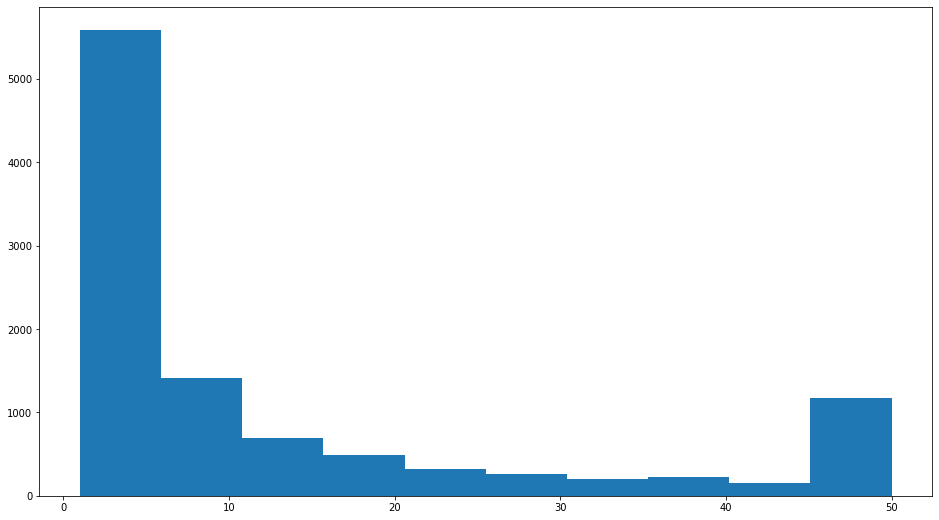

In [70]:
plt.figure(figsize=(16,9))
plt.hist(data=df_train,x='nummosquitos');

### EDA - Combined dataset

In [71]:
# Creating a new column is_spray and setting all cells as False
df_train['is_spray'] = False

In [72]:
# Setting time delta as 30 days. The spray lasts
# A typical mosquito treatment lasts about 30 days. 
# https://www.callnorthwest.com/2019/05/how-long-does-a-mosquito-treatment-last/
tdelta_min = dt.timedelta(days=0)
tdelta_max = dt.timedelta(days=30)

# Looping through df with min,max latitudes and longitudes
for i,spray in min_max_spray.iterrows():
    long_min = spray['longitude_min']
    long_max = spray['longitude_max']
    lat_min = spray['latitude_min']
    lat_max = spray['latitude_max']
# Looping through train df, checking is latitudes and longitudes lay between min and max
# and date is the same date or date +30 days of spraying 
    for j,row in df_train.iterrows():
        if (tdelta_min < (row['date']-spray['date']) <=tdelta_max):
            if ((lat_min <= row['latitude'] <= lat_max) &
                (long_min <= row['longitude'] <= long_max)):
                df_train.loc[j,'is_spray'] = True

In [73]:
# Checking number of rows in train which were sprayed
df_train['is_spray'].value_counts()

False    10280
True       226
Name: is_spray, dtype: int64

In [74]:
# Merging weather and train df
main_df = pd.merge(df_train,df_weather_st1, on=['date','year','month','day'])
main_df.head()

,date,address,species,block,street,trap,addressnumberandstreet,latitude,longitude,addressaccuracy,...,sunset,codesum,depth,snowfall,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,...,1917.0,BR HZ,0,0.0,0.0,29.39,30.11,5.8,18,6.5
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,...,1917.0,BR HZ,0,0.0,0.0,29.39,30.11,5.8,18,6.5
2,2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,...,1917.0,BR HZ,0,0.0,0.0,29.39,30.11,5.8,18,6.5
3,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX PIPIENS/RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,...,1917.0,BR HZ,0,0.0,0.0,29.39,30.11,5.8,18,6.5
4,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,...,1917.0,BR HZ,0,0.0,0.0,29.39,30.11,5.8,18,6.5


In [75]:
main_df.isnull().sum()

date                      0
address                   0
species                   0
block                     0
street                    0
trap                      0
addressnumberandstreet    0
latitude                  0
longitude                 0
addressaccuracy           0
nummosquitos              0
wnvpresent                0
day                       0
month                     0
year                      0
iswnvspecies              0
is_spray                  0
station                   0
tmax                      0
tmin                      0
tavg                      0
depart                    0
dewpoint                  0
wetbulb                   0
heat                      0
cool                      0
sunrise                   0
sunset                    0
codesum                   0
depth                     0
snowfall                  0
preciptotal               0
stnpressure               0
sealevel                  0
resultspeed               0
resultdir           

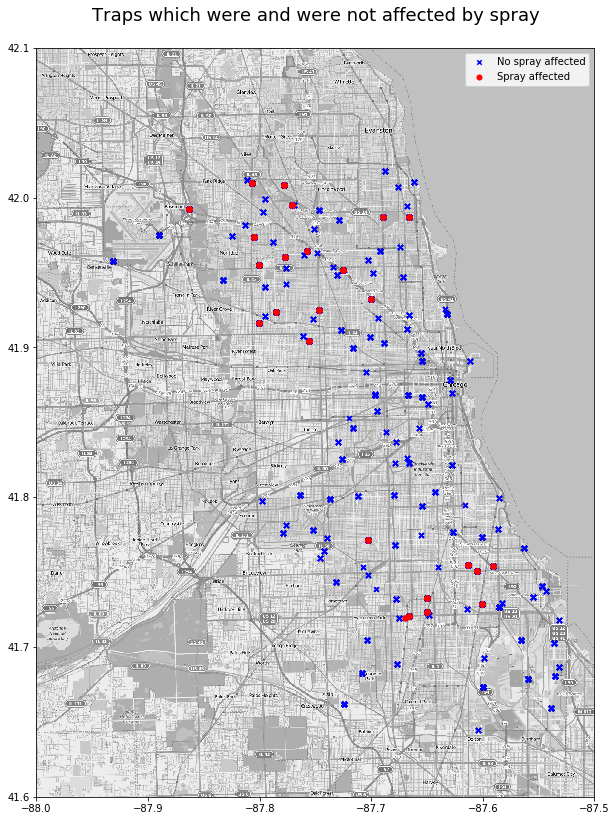

In [76]:
spray_traps = main_df[main_df['is_spray']==True]
spray_no_traps = main_df[main_df['is_spray']==False]

lats_spray = spray_traps['latitude']
longs_spray = spray_traps['longitude']
lats_no_spray = spray_no_traps['latitude']
longs_no_spray = spray_no_traps['longitude']

f.gen_map()

plt.scatter(x=longs_no_spray, y=lats_no_spray, c='b', s=20, marker='x',label='No spray affected')
plt.scatter(x=longs_spray, y=lats_spray, c='r', s=25,label='Spray affected')
plt.title('Traps which were and were not affected by spray\n',fontsize=18)
plt.legend()
plt.show();

In [77]:
main_df.columns

Index(['date', 'address', 'species', 'block', 'street', 'trap',
       'addressnumberandstreet', 'latitude', 'longitude', 'addressaccuracy',
       'nummosquitos', 'wnvpresent', 'day', 'month', 'year', 'iswnvspecies',
       'is_spray', 'station', 'tmax', 'tmin', 'tavg', 'depart', 'dewpoint',
       'wetbulb', 'heat', 'cool', 'sunrise', 'sunset', 'codesum', 'depth',
       'snowfall', 'preciptotal', 'stnpressure', 'sealevel', 'resultspeed',
       'resultdir', 'avgspeed'],
      dtype='object')

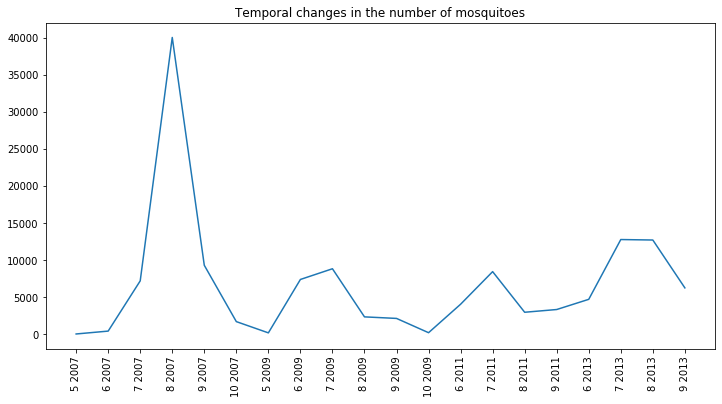

In [78]:
# Visualisation of temporal trend of number of mosquitoes 
main_df['month'] = main_df['date'].map(lambda x: x.month)
num_mosq_month = main_df.groupby(['year','month'])['nummosquitos'].sum().reset_index(level=[0,1])
plt.figure(figsize=(12,6))
plt.plot(num_mosq_month['nummosquitos'])
plt.xticks(range(len(num_mosq_month)),
labels=list(num_mosq_month['month'].astype('str')+' '+num_mosq_month['year'].astype('str')),
          rotation='vertical')
plt.title('Temporal changes in the number of mosquitoes');

From the linegraph it can be seen that the train dataset contain information only about 5th,6th,7th,8th,9th and 10th months of 2007,2009,2011 and 2013 years.

The biggest numbers of mosquitoes are in 7th and 8th each year.

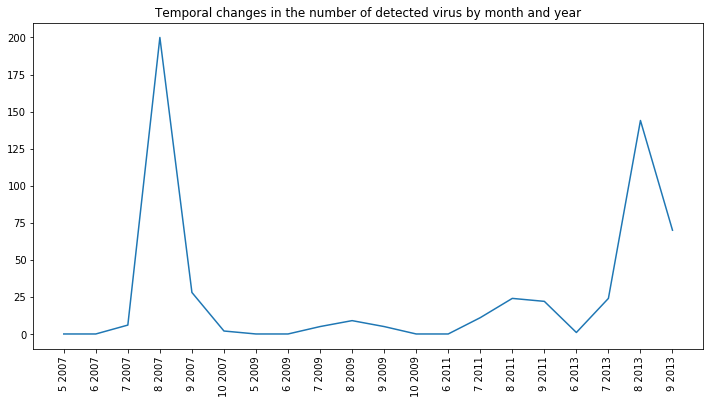

In [79]:
# Plot total count of traps with virus per month over time
num_mosq_month = main_df.groupby(['year','month'])['wnvpresent'].sum().reset_index(level=[0,1])
plt.figure(figsize=(12,6))
plt.plot(num_mosq_month['wnvpresent'])
plt.xticks(range(len(num_mosq_month)),
labels=list(num_mosq_month['month'].astype('str')+' '+num_mosq_month['year'].astype('str')),
          rotation='vertical')
plt.title('Temporal changes in the number of detected virus by month and year');

**Comment**

The linegraph illustrate that high number of virus was detected in month 8.

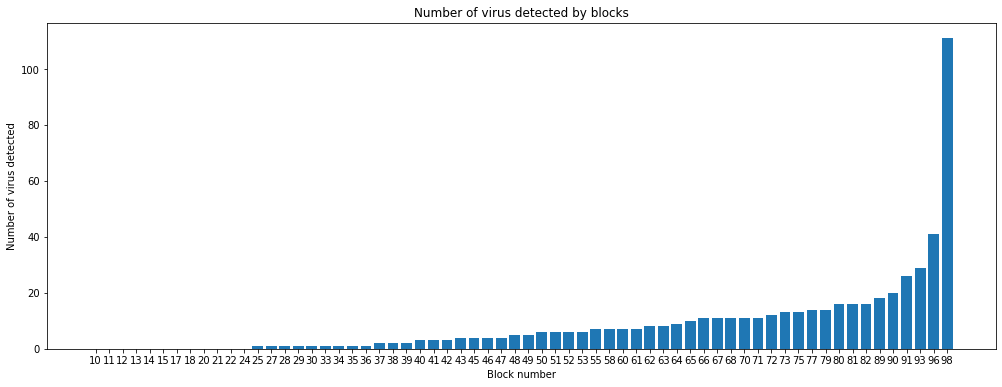

In [80]:
plt.figure(figsize=(17,6))
plt.bar(range(len(main_df['block'].unique())), main_df.groupby('block')['wnvpresent'].sum().sort_values())
plt.xlabel('Block number')
plt.ylabel('Number of virus detected')
plt.title('Number of virus detected by blocks')
plt.xticks(range(len(main_df['block'].unique())),labels=sorted(main_df['block'].unique()));

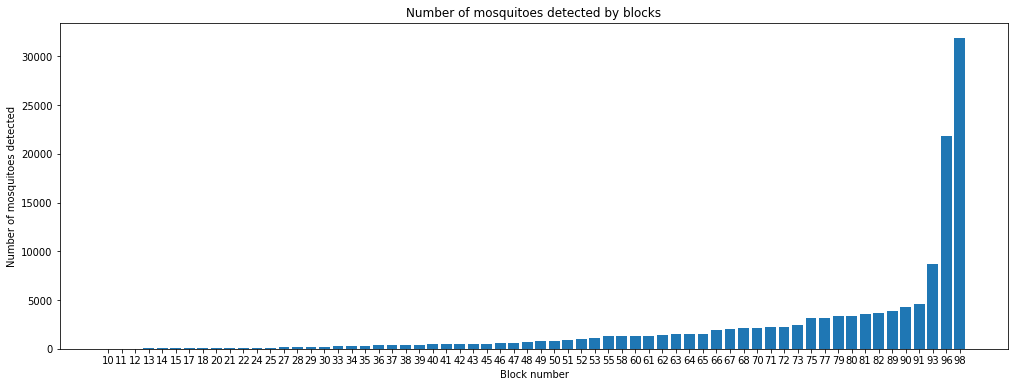

In [81]:
plt.figure(figsize=(17,6))
plt.bar(range(len(main_df['block'].unique())), main_df.groupby('block')['nummosquitos'].sum().sort_values())
plt.xlabel('Block number')
plt.ylabel('Number of mosquitoes detected')
plt.title('Number of mosquitoes detected by blocks')
plt.xticks(range(len(main_df['block'].unique())),labels=sorted(main_df['block'].unique()));

**Comment**

It can be seen that 10th block have the anomaly high number of virus detected and number of mosquitoes.

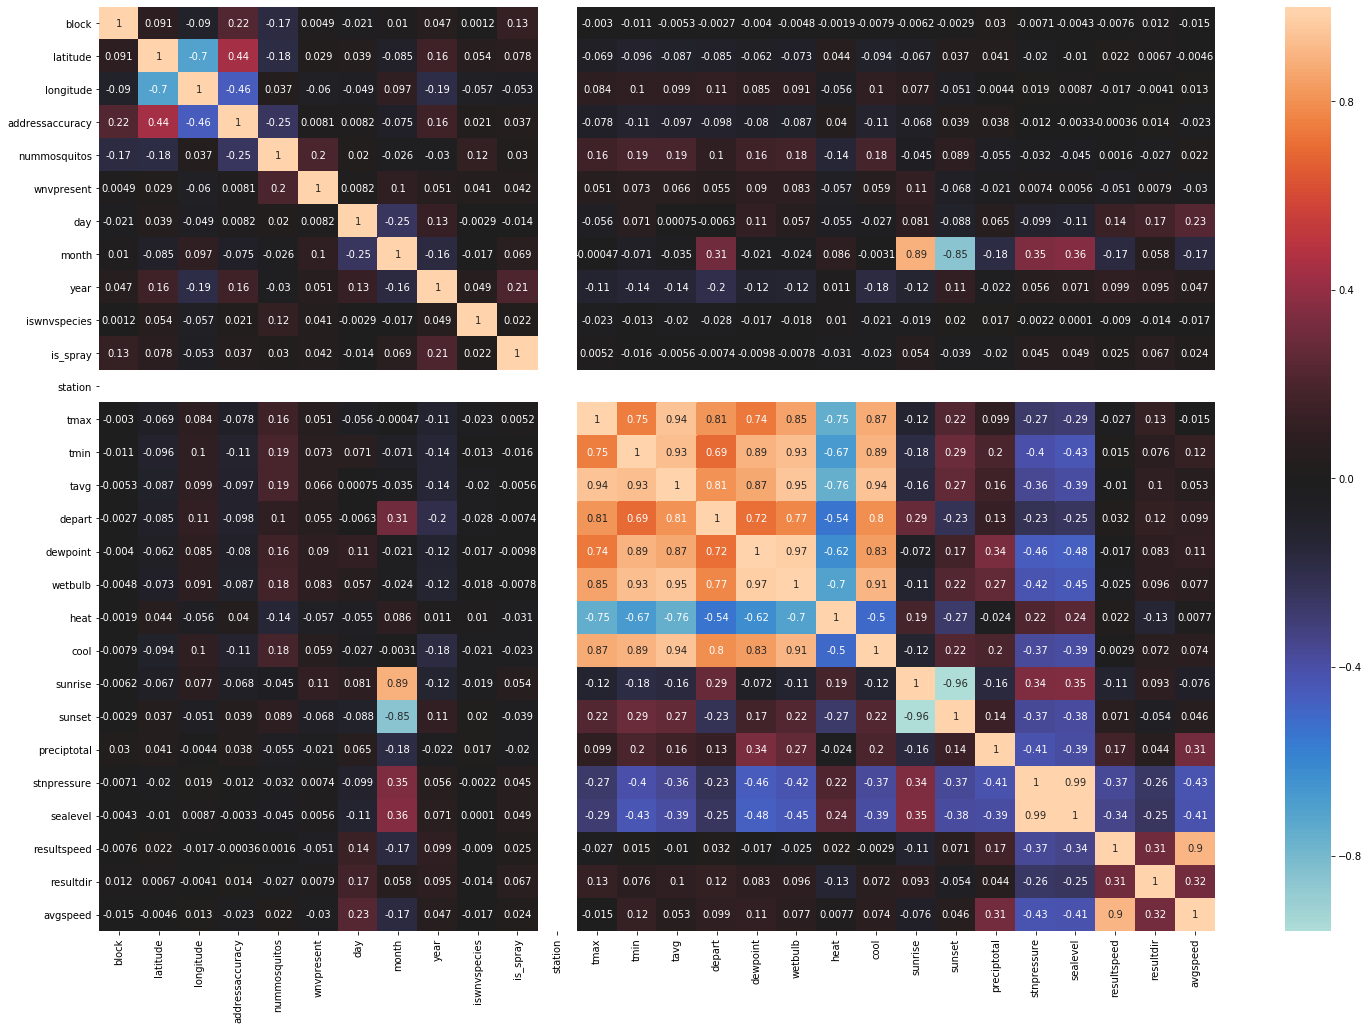

In [82]:
plt.figure(figsize=(25,17))
sns.heatmap(main_df.corr(),annot=True,center=0);

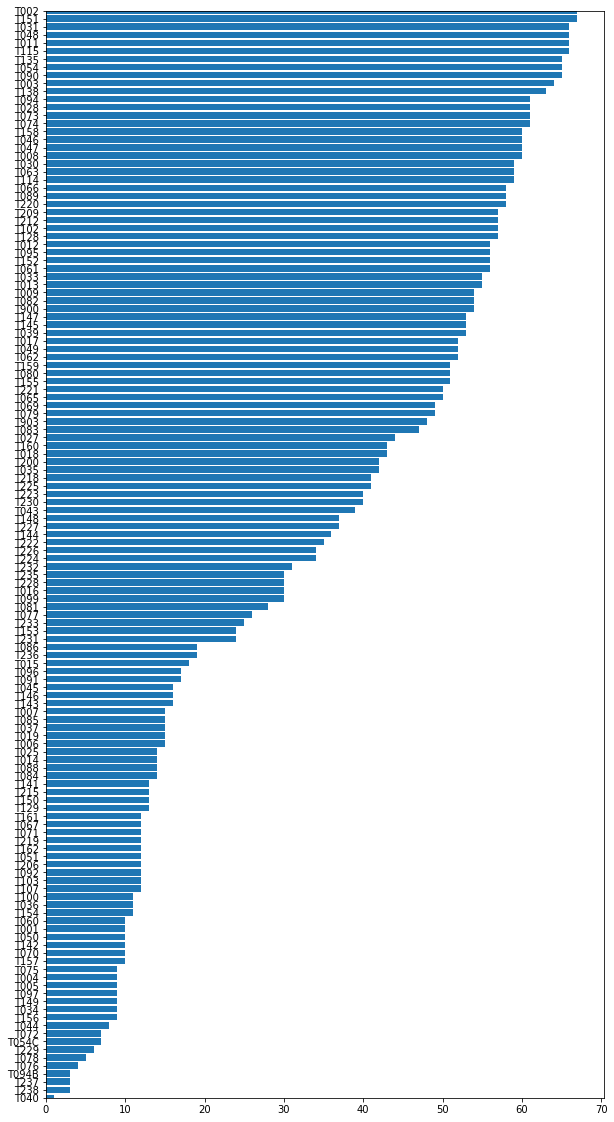

In [83]:
# number of mosq species carry a virus by traps
bin = np.arange(135)
plt.figure(figsize=(10,20))
grouped = df_train_bydate_trap.groupby('trap')['iswnvspecies'].sum()
grouped.sort_values(inplace=True)
plt.barh(grouped.index,grouped.values)
plt.yticks(range(len(grouped.index)),labels=grouped.index)
plt.ylim([0,bin.size]);

## Bryan Pushing his model here /START

In [1126]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier

from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, VotingClassifier, AdaBoostClassifier
from sklearn.utils import resample

In [605]:
# Obtain top WNV hotspots for streets and traps

grouped_street = df_train_bydate_trap.groupby('street')['wnvpresent'].sum()
grouped_street.sort_values(inplace=True)

grouped_trap = df_train_bydate_trap.groupby('trap')['wnvpresent'].sum()
grouped_trap.sort_values(inplace=True)

In [1069]:
# Copy DF

main_df_bryan = main_df

# Binary for is_spray

main_df_bryan['is_spray'] = [int(row == True) for row in main_df_bryan['is_spray']]

In [1071]:
main_df_bryan = pd.merge(main_df_bryan, species_weight, on="species")

In [1072]:
main_df_bryan = pd.merge(main_df_bryan, trap_weight, on="trap")

In [1073]:
main_df_bryan.columns

Index(['date', 'address', 'species', 'block', 'street', 'trap',
       'addressnumberandstreet', 'latitude', 'longitude', 'addressaccuracy',
       'nummosquitos', 'wnvpresent', 'day', 'month', 'year', 'iswnvspecies',
       'is_spray', 'station', 'tmax', 'tmin', 'tavg', 'depart', 'dewpoint',
       'wetbulb', 'heat', 'cool', 'sunrise', 'sunset', 'codesum', 'depth',
       'snowfall', 'preciptotal', 'stnpressure', 'sealevel', 'resultspeed',
       'resultdir', 'avgspeed', 'speciesweight', 'trapweight'],
      dtype='object')

In [1077]:
# Select key features for our model fitting

feature_columns = ['month', 'year', 'block', 'is_spray', 'dewpoint','wnvpresent', 'sunrise','sunset', 'latitude', 'longitude', 'addressaccuracy', 'tavg','tmin', 'tmax']

In [1078]:
# Select species that carry WNV

top_species = ['CULEX PIPIENS/RESTUANS', 'CULEX RESTUANS', 'CULEX PIPIENS']

# Select the top 20 traps that have the highest ratio of WNV

top_traps = grouped_trap.sort_values(ascending=False)
top_traps = top_traps.index[:20].tolist()

# Select the top 5 streets that have the highest ratio of WNV

top_street = grouped_street.sort_values(ascending=False)
top_street = top_street.index[:5].tolist()

In [1079]:
# Create dummy variables of top species, traps and streets

species_dummy = pd.get_dummies(main_df_bryan['species'], drop_first = True)
species_dummy = species_dummy.loc[:,top_species]

traps_dummy = pd.get_dummies(main_df_bryan['trap'], drop_first=True)
traps_dummy = traps_dummy.loc[:, top_traps]

street_dummy = pd.get_dummies(main_df_bryan['street'], drop_first=True)
street_dummy = street_dummy.loc[:, top_street]

traps_dummy.head()

,T900,T003,T002,T115,T225,T011,T013,T223,T008,T138,T114,T082,T030,T090,T061,T151,T128,T009,T903,T221
0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [1080]:
# Select key features

main_df_bryan = main_df_bryan.loc[:, feature_columns]
main_df_bryan.head()

,month,year,block,is_spray,dewpoint,wnvpresent,sunrise,sunset,latitude,longitude,addressaccuracy,tavg,tmin,tmax
0,5,2007,41,0,14.44,0,421.0,1917.0,41.95469,-87.800991,9,23.33,15.56,31.11
1,6,2007,41,0,8.89,0,417.0,1923.0,41.95469,-87.800991,9,13.33,8.33,17.78
2,6,2007,41,0,20.56,0,418.0,1931.0,41.95469,-87.800991,9,27.22,21.11,33.33
3,6,2007,41,0,12.78,0,419.0,1931.0,41.95469,-87.800991,9,17.22,13.33,21.11
4,7,2007,41,0,10.00,0,420.0,1931.0,41.95469,-87.800991,9,18.89,11.67,26.11


In [1081]:
main_df_bryan = pd.concat([main_df_bryan,traps_dummy],axis=1)
main_df_bryan = pd.concat([main_df_bryan,street_dummy],axis=1)
main_df_bryan = pd.concat([main_df_bryan,species_dummy],axis=1)
main_df_bryan.head()

,month,year,block,is_spray,dewpoint,wnvpresent,sunrise,sunset,latitude,longitude,...,T903,T221,W OHARE AIRPORT,N OAK PARK AVE,N MILWAUKEE AVE,S DOTY AVE,S KOSTNER AVE,CULEX PIPIENS/RESTUANS,CULEX RESTUANS,CULEX PIPIENS
0,5,2007,41,0,14.44,0,421.0,1917.0,41.95469,-87.800991,...,0,0,0,1,0,0,0,1,0,0
1,6,2007,41,0,8.89,0,417.0,1923.0,41.95469,-87.800991,...,0,0,0,1,0,0,0,1,0,0
2,6,2007,41,0,20.56,0,418.0,1931.0,41.95469,-87.800991,...,0,0,0,1,0,0,0,1,0,0
3,6,2007,41,0,12.78,0,419.0,1931.0,41.95469,-87.800991,...,0,0,0,1,0,0,0,1,0,0
4,7,2007,41,0,10.00,0,420.0,1931.0,41.95469,-87.800991,...,0,0,0,1,0,0,0,1,0,0


In [1082]:
main_df_bryan['wnvpresent'].value_counts(normalize=True)

0    0.947554
1    0.052446
Name: wnvpresent, dtype: float64

In [1083]:
feature_columns.extend(top_traps)
feature_columns.extend(top_street)
feature_columns.extend(top_species)
feature_columns

['month',
 'year',
 'block',
 'is_spray',
 'dewpoint',
 'wnvpresent',
 'sunrise',
 'sunset',
 'latitude',
 'longitude',
 'addressaccuracy',
 'tavg',
 'tmin',
 'tmax',
 'T900',
 'T003',
 'T002',
 'T115',
 'T225',
 'T011',
 'T013',
 'T223',
 'T008',
 'T138',
 'T114',
 'T082',
 'T030',
 'T090',
 'T061',
 'T151',
 'T128',
 'T009',
 'T903',
 'T221',
 ' W OHARE AIRPORT',
 ' N OAK PARK AVE',
 ' N MILWAUKEE AVE',
 ' S DOTY AVE',
 ' S KOSTNER AVE',
 'CULEX PIPIENS/RESTUANS',
 'CULEX RESTUANS',
 'CULEX PIPIENS']

In [1084]:
X = main_df_bryan[feature_columns]
y = main_df_bryan['wnvpresent']

X.drop(columns='wnvpresent', inplace=True)

X.shape

(10506, 41)

In [1085]:
y.shape

(10506,)

In [1086]:
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42, test_size=0.25, stratify=y)

In [1087]:
y_train.value_counts()

0    7466
1     413
Name: wnvpresent, dtype: int64

In [1088]:
X = pd.concat([X_train, y_train], axis=1)
X.head()

,month,year,block,is_spray,dewpoint,sunrise,sunset,latitude,longitude,addressaccuracy,...,T221,W OHARE AIRPORT,N OAK PARK AVE,N MILWAUKEE AVE,S DOTY AVE,S KOSTNER AVE,CULEX PIPIENS/RESTUANS,CULEX RESTUANS,CULEX PIPIENS,wnvpresent
9929,8,2013,51,1,13.33,452.0,1903.0,41.973845,-87.805059,9,...,0,0,0,0,0,0,1,0,0,1
7808,7,2011,24,0,15.56,429.0,1926.0,41.704572,-87.565666,8,...,0,0,0,0,0,0,0,1,0,0
8148,9,2007,89,0,17.22,521.0,1821.0,41.733643,-87.555510,8,...,0,0,0,0,0,0,1,0,0,0
2409,7,2007,58,0,10.00,420.0,1931.0,41.986921,-87.689778,9,...,0,0,0,0,0,0,0,0,1,0
478,7,2009,22,0,17.78,425.0,1929.0,41.921965,-87.632085,8,...,0,0,0,0,0,0,0,1,0,0


In [1089]:
# separate minority and majority classes
wnv_false = X[X.wnvpresent==0]
wnv_true = X[X.wnvpresent==1]

# upsample minority
wnv_upsampled = resample(wnv_true,
                          replace=True, # sample with replacement
                          n_samples=len(wnv_false), # match number in majority class
                          random_state=42) # reproducible results

# combine majority and upsampled minority
upsampled = pd.concat([wnv_false, wnv_upsampled])

# check new wnvpresent counts
upsampled.wnvpresent.value_counts()

1    7466
0    7466
Name: wnvpresent, dtype: int64

In [1090]:
# update our training data with the upsampled data

X_train = upsampled.drop('wnvpresent',axis=1)
y_train = upsampled.wnvpresent

In [1091]:
# Baseline accuracy 50% due to upsampling

y_train.value_counts()

1    7466
0    7466
Name: wnvpresent, dtype: int64

In [1092]:
X_train.shape

(14932, 41)

In [1093]:
y_train.shape

(14932,)

#### Testing Various other models

In [1128]:
# Fit various models

# Decision Trees
rfc = RandomForestClassifier(random_state=42).fit(X_train, y_train)
et = ExtraTreesClassifier(random_state=42).fit(X_train, y_train)

# Boosting
gboost = GradientBoostingClassifier(random_state=42).fit(X_train, y_train)
adaboost = AdaBoostClassifier(random_state=42).fit(X_train, y_train)

# Logistic Regression
lr = LogisticRegression(solver='liblinear', random_state=42).fit(X_train, y_train)

# KNearestNeighbors
knn = KNeighborsClassifier().fit(X_train, y_train)

In [1129]:
# Observe general train / test accuracy for all models
# Extra Trees perform the best with 86% accuracy for our validation data
# All models appear to be overfit

print ('rfc train : {}'.format(rfc.score(X_train, y_train)))
print ('rfc test : {}'.format(rfc.score(X_test, y_test)))
print ('')
print ('et train : {}'.format(et.score(X_train, y_train)))
print ('et test : {}'.format(et.score(X_test, y_test)))
print ('')
print ('adaboost train : {}'.format(adaboost.score(X_train, y_train)))
print ('adaboost test : {}'.format(adaboost.score(X_test, y_test)))
print ('')
print ('gboost train : {}'.format(gboost.score(X_train, y_train)))
print ('gboost test : {}'.format(gboost.score(X_test, y_test)))
print ('')
print ('lr train : {}'.format(lr.score(X_train, y_train)))
print ('lr test : {}'.format(lr.score(X_test, y_test)))
print ('')
print ('knn train : {}'.format(knn.score(X_train, y_train)))
print ('knn test : {}'.format(knn.score(X_test, y_test)))

rfc train : 0.9693945888025717
rfc test : 0.8976018271792919

et train : 0.9693945888025717
et test : 0.9029311001141987

adaboost train : 0.7810742030538441
adaboost test : 0.7365816520746098

gboost train : 0.8286230913474417
gboost test : 0.7754092120289303

lr train : 0.7156442539512456
lr test : 0.6844309097830225

knn train : 0.9338333779801768
knn test : 0.8462124095926913


In [1096]:
tn, fp, fn, tp = confusion_matrix(y_test, et.predict(X_test)).ravel()

print("Extra Trees Confusion Matrix")
print("")
print("True Negatives: %s" % tn)
print("False Positives: %s" % fp)
print("False Negatives: %s" % fn)
print("True Positives: %s" % tp)
print("")
print("Precision: %s" % round((tp/(tp+fp)),2))
print("Recall: %s" % round((tp/(tp+fn)),2))

Extra Trees Confusion Matrix

True Negatives: 2333
False Positives: 156
False Negatives: 99
True Positives: 39

Precision: 0.2
Recall: 0.28


In [1130]:
tn, fp, fn, tp = confusion_matrix(y_test, knn.predict(X_test)).ravel()

print("K-Nearest Neighbors Confusion Matrix")
print("")
print("True Negatives: %s" % tn)
print("False Positives: %s" % fp)
print("False Negatives: %s" % fn)
print("True Positives: %s" % tp)
print("")
print("Precision: %s" % round((tp/(tp+fp)),2))
print("Recall: %s" % round((tp/(tp+fn)),2))

K-Nearest Neighbors Confusion Matrix

True Negatives: 2158
False Positives: 331
False Negatives: 73
True Positives: 65

Precision: 0.16
Recall: 0.47


In [1097]:
tn, fp, fn, tp = confusion_matrix(y_test, gboost.predict(X_test)).ravel()

print("Gradient Boost Confusion Matrix")
print("")
print("True Negatives: %s" % tn)
print("False Positives: %s" % fp)
print("False Negatives: %s" % fn)
print("True Positives: %s" % tp)
print("")
print("Precision: %s" % round((tp/(tp+fp)),2))
print("Recall: %s" % round((tp/(tp+fn)),2))

Gradient Boost Confusion Matrix

True Negatives: 1933
False Positives: 556
False Negatives: 34
True Positives: 104

Precision: 0.16
Recall: 0.75


In [1105]:
gboost = GradientBoostingClassifier(random_state=42, n_estimators=100).fit(X_train, y_train)
gb_pred = gboost.predict(X_test)

In [1106]:
pd.DataFrame(confusion_matrix(y_test, gb_pred))

,0,1
0,1933,556
1,34,104


#### ROC AUC

In [1107]:
# Import roc_auc_score.
from sklearn.metrics import roc_auc_score

# Create a dataframe called pred_df that contains:
# 1. The list of true values of our test set.
# 2. The list of predicted probabilities based on our model.

pred_proba = [i[1] for i in gboost.predict_proba(X_test)]

pred_df = pd.DataFrame({'true_values': y_test,
                        'pred_probs':pred_proba})

# Calculate ROC AUC

roc_auc_score(pred_df['true_values'], pred_df['pred_probs'])

0.844274226888163

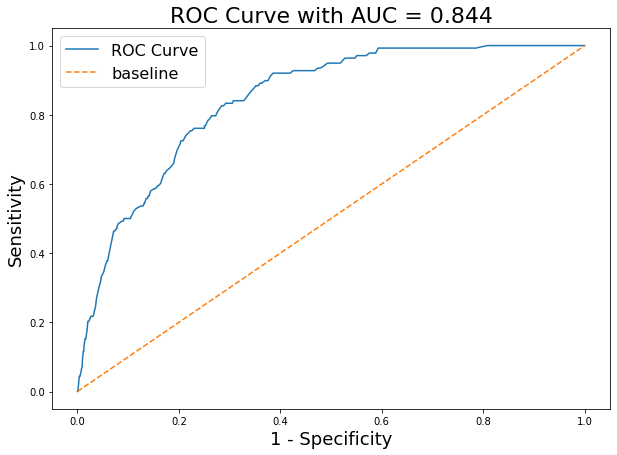

In [1108]:
# Create figure.
plt.figure(figsize = (10,7))

# Create threshold values. (Dashed red line in image.)
thresholds = np.linspace(0, 1, 200)

# Define function to calculate sensitivity. (True positive rate.)
def TPR(df, true_col, pred_prob_col, threshold):
    true_positive = df[(df[true_col] == 1) & (df[pred_prob_col] >= threshold)].shape[0]
    false_negative = df[(df[true_col] == 1) & (df[pred_prob_col] < threshold)].shape[0]
    return true_positive / (true_positive + false_negative)
    

# Define function to calculate 1 - specificity. (False positive rate.)
def FPR(df, true_col, pred_prob_col, threshold):
    true_negative = df[(df[true_col] == 0) & (df[pred_prob_col] <= threshold)].shape[0]
    false_positive = df[(df[true_col] == 0) & (df[pred_prob_col] > threshold)].shape[0]
    return 1 - (true_negative / (true_negative + false_positive))
    
# Calculate sensitivity & 1-specificity for each threshold between 0 and 1.
tpr_values = [TPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]
fpr_values = [FPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]

# Plot ROC curve.
plt.plot(fpr_values, # False Positive Rate on X-axis
         tpr_values, # True Positive Rate on Y-axis
         label='ROC Curve')

# Plot baseline. (Perfect overlap between the two populations.)
plt.plot(np.linspace(0, 1, 200),
         np.linspace(0, 1, 200),
         label='baseline',
         linestyle='--')

# Label axes.
plt.title(f'ROC Curve with AUC = {round(roc_auc_score(pred_df["true_values"], pred_df["pred_probs"]),3)}', fontsize=22)
plt.ylabel('Sensitivity', fontsize=18)
plt.xlabel('1 - Specificity', fontsize=18)

# Create legend.
plt.legend(fontsize=16);

In [1109]:
df_test.columns

Index(['id', 'date', 'address', 'species', 'block', 'street', 'trap',
       'addressnumberandstreet', 'latitude', 'longitude', 'addressaccuracy'],
      dtype='object')

In [1110]:
df_test.shape

(116293, 11)

In [1131]:
df_test_bryan = df_test

In [1134]:
# Codes
df_test_bryan.columns = df_test_bryan.columns.str.lower()
df_test_bryan['date'] = pd.to_datetime(df_test_bryan['date'])
# Create temproray dataframe by merging cleaned df_test_bryan and df_weather dataframes

df = pd.merge(df_test_bryan, df_weather_st1, on="date")
# Create dummy variables of top species, traps and streets

species_dummy = pd.get_dummies(df['species'], drop_first = True)
species_dummy = species_dummy.loc[:,top_species]

traps_dummy = pd.get_dummies(df['trap'], drop_first=True)
traps_dummy = traps_dummy.loc[:, top_traps]

street_dummy = pd.get_dummies(df['street'], drop_first=True)
street_dummy = street_dummy.loc[:, top_street]

df = pd.concat([df,traps_dummy],axis=1)
df = pd.concat([df,street_dummy],axis=1)
df = pd.concat([df,species_dummy],axis=1)

# Select key features

df = df.loc[:, feature_columns]

df.head()

C:\Users\admin\Anaconda3\lib\site-packages\pandas\core\indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


,month,year,block,is_spray,dewpoint,wnvpresent,sunrise,sunset,latitude,longitude,...,T903,T221,W OHARE AIRPORT,N OAK PARK AVE,N MILWAUKEE AVE,S DOTY AVE,S KOSTNER AVE,CULEX PIPIENS/RESTUANS,CULEX RESTUANS,CULEX PIPIENS
0,6,2008,41,NaN,13.33,NaN,416.0,1926.0,41.95469,-87.800991,...,0,0,0,1,0,0,0,1,0,0
1,6,2008,41,NaN,13.33,NaN,416.0,1926.0,41.95469,-87.800991,...,0,0,0,1,0,0,0,0,1,0
2,6,2008,41,NaN,13.33,NaN,416.0,1926.0,41.95469,-87.800991,...,0,0,0,1,0,0,0,0,0,1
3,6,2008,41,NaN,13.33,NaN,416.0,1926.0,41.95469,-87.800991,...,0,0,0,1,0,0,0,0,0,0
4,6,2008,41,NaN,13.33,NaN,416.0,1926.0,41.95469,-87.800991,...,0,0,0,1,0,0,0,0,0,0


In [1135]:
# Create an empty dataframe
submission = pd.DataFrame()

# Assign a column 'Id' with values identical to the test dataframe
submission['id'] = df_test_bryan.id

In [1136]:
# Get our test dataframe with our feature columns
# This is equivalent to 'X' in our training data
feats = df[feature_columns]
feats.drop(columns='wnvpresent',inplace=True)

In [1138]:
feats.fillna(0, inplace=True)

In [1139]:
feats.isnull().sum()

month                     0
year                      0
block                     0
is_spray                  0
dewpoint                  0
sunrise                   0
sunset                    0
latitude                  0
longitude                 0
addressaccuracy           0
tavg                      0
tmin                      0
tmax                      0
T900                      0
T003                      0
T002                      0
T115                      0
T225                      0
T011                      0
T013                      0
T223                      0
T008                      0
T138                      0
T114                      0
T082                      0
T030                      0
T090                      0
T061                      0
T151                      0
T128                      0
T009                      0
T903                      0
T221                      0
 W OHARE AIRPORT          0
 N OAK PARK AVE           0
 N MILWAUKEE AVE    

In [1140]:
# Perform predictions of WNV Present based on our selected features
# with our Gradient Boosting Model

predictions = gboost.predict(feats)

In [1141]:
predictions.shape

(116293,)

In [1142]:
submission.shape

(116293, 1)

In [1143]:
submission

,id
0,1
1,2
2,3
3,4
4,5
...,...
116288,116289
116289,116290
116290,116291
116291,116292


In [1144]:
# Input our predictions into a new column for our submission
# matching the wnv classification to the respective Id
submission['wnvpresent'] = predictions
submission.head()

,id,wnvpresent
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


In [1145]:
# Save our dataframe into a csv file for submission
submission.to_csv('submission.csv', index=False)

# 0.64 Public Score 0.59 Private Score

## Bryan Pushing his model here /END